# **Neural steering controller for an artificial race driver (ARD)**

This model implements the physics-driven neural steering controller in Fig. 8b of the paper titled:

*A Physics-Driven Artificial Agent for Online Time-Optimal Vehicle Motion Planning and Control*

(available at https://ieeexplore.ieee.org/abstract/document/101225395)

This NN controls the combined lateral steering dynamics of a race car. 

## Initialization

### Import packages

In [1]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.initializer import *
from nnodely.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely import relation
from nnodely import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>- nnodely_v0.14.3 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Current working directory:  /Users/mattiapiccinini/Documents/Research/NNodely/nnodely-applications/vehicle/control_steer_artificial_race_driver_extended


### Configurations and known constant parameters

In [2]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'dataset')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map_values = np.float64(np.deg2rad(steer_map_load[:,0]))
delta_w_avg_map_values = delta_w_avg_map_values[:,np.newaxis].tolist()  # add a dimension
delta_sw_map_values = np.float64(np.deg2rad(steer_map_load[:,1]))
delta_sw_map_values = delta_sw_map_values[:,np.newaxis].tolist()  # add a dimension

## NN model

### Custom parametric functions

In [3]:
# -------------------------------------------------
# Normalization function
# -------------------------------------------------
def normalize_fun(x,x_max):
  return x/x_max

# -------------------------------------------------
# Saturation function
# -------------------------------------------------
def sat_fun(x,x_min,x_max):
  return torch.min(torch.max(x,x_min),x_max)

# -------------------------------------------------
# Absolute value function
# -------------------------------------------------
def abs_fun(x):
  return torch.abs(x)

# -------------------------------------------------
# Handling diagram
# -------------------------------------------------
def handling_diagr_local(curv,ay,ax,az,vx_norm,  # inputs
                         ay_0,ax_0,az_0,L,       # constants
                         k1_vx,k2_vx,            # learnable arrays of parameters
                         S_ay,S_ax,S_az          # learnable arrays of parameters
                         ):
  sign_ay = torch.sign(ay)  # sign of the lateral acceleration

  # compute k1, as a function of vx 
  k1_vx_fun = k1_vx[0,0,0]
  for ii in range(1,k1_vx.size(2)):
    k1_vx_fun = k1_vx_fun + k1_vx[0,0,ii]*torch.pow(vx_norm,ii)

  # compute k2, as a function of vx
  k2_vx_fun = k2_vx[0,0,0]
  for ii in range(1,k2_vx.size(2)):
    k2_vx_fun = k2_vx_fun + k2_vx[0,0,ii]*torch.pow(vx_norm,ii)

  # learnable weights of the local model for ay around ay_0
  S_ay_1 = S_ay[0,0,0]
  S_ay_2 = S_ay[0,0,1]
  S_ay_3 = S_ay[0,0,2]
  S_ay_4 = S_ay[0,0,3]

  # learnable weights of the local model for ax around ax_0
  S_ax_1 = S_ax[0,0,0]
  S_ax_2 = S_ax[0,0,1]
  S_ax_3 = S_ax[0,0,2]
  S_ax_4 = S_ax[0,0,3]
  S_ax_5 = S_ax[0,0,4]

  # learnable weights of the local model for az around az_0
  S_az_1 = S_az[0,0,0]
  S_az_2 = S_az[0,0,1]
  S_az_3 = S_az[0,0,2]
  S_az_4 = S_az[0,0,3]
  S_az_5 = S_az[0,0,4]
  S_az_6 = S_az[0,0,5]
    
  # output of the local model of the handling diagram
  output = curv*L + k1_vx_fun*sign_ay + k2_vx_fun*(ay - ay_0*sign_ay) + \
           S_az_1*(ay - ay_0*sign_ay)*(az - az_0) + S_az_2*(ay - ay_0*sign_ay)*(az - az_0)**2 + \
           S_ay_1*S_ax_1*(1 + S_az_3)*(ay - (ay_0+S_ay_2)*sign_ay)*(S_ax_2 + ax - ax_0)*(1 + \
           S_ay_3*(ay - ay_0*sign_ay) + S_ax_3*(ax - ax_0) + S_ax_4*(ax - ax_0)**2 + \
           S_az_4*(az - az_0) + S_az_5*(az - az_0)**2 + S_az_6*(az - az_0)*(ax - ax_0) + \
           S_ay_4*S_ax_5*(ay - ay_0*sign_ay)*(ax - ax_0))
  return output

### Hyperparameters and configurations for the internal model

In [4]:
# -----------------------------------------------
# Saturation values for the inputs
# -----------------------------------------------
# Load the training and validation data
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')

# Extract the max values of ay and vx from the training set
max_ay   = max(abs(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ay'].values)).item()
max_curv = max(abs(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['curvat_trans'].values)).item()

min_vx = min(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values).item()
max_vx = max(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values).item()

min_ax = np.percentile(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ax'].values,0.2,axis=0).item()
max_ax = np.percentile(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ax'].values,99.92,axis=0).item()

min_az = min(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['az'].values).item()
max_az = max(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['az'].values).item()

print('max_ay   = ', max_ay)
print('max_curv = ', max_curv)
print('min_vx   = ', min_vx)
print('max_vx   = ', max_vx)
print('min_ax   = ', min_ax)
print('max_ax   = ', max_ax)
print('min_az   = ', min_az)
print('max_az   = ', max_az)

# -----------------------------------------------
# Window sizes, channels, and others
# -----------------------------------------------
# Window size for the inputs
num_samples_future_feedfw = 15   # number of future samples in the feedforward part of the model

# Channels for the lateral acceleration ay
num_channels_ay = 6
chan_centers_ay = list(np.linspace(0.0, max_ay + 1.0, num_channels_ay))  # centers of the channels

# Channels for the forward speed vx
num_channels_vx = 7
chan_centers_vx = list(np.linspace(9, 90, num=num_channels_vx))  # centers of the channels

# Channels for the longitudinal acceleration ax
num_channels_ax         = 6
perc_neg_ax             = 0.5   # percentage of channels dedicated to negative ax
extra_margin_ax_centers = 0.5   # extra margin for the centers of the channels
# Define the center points of the channels (make sure to capture ax = 0)
chan_centers_ax = np.linspace(min_ax - extra_margin_ax_centers, 0, num=int(num_channels_ax*perc_neg_ax), endpoint=False)
chan_centers_ax = list(np.append(chan_centers_ax, np.linspace(0, max_ax + extra_margin_ax_centers, 
                                                              num=num_channels_ax - int(num_channels_ax*perc_neg_ax))))

# Channels for the vertical acceleration az
num_channels_az = 1  # number of channels --> only 1, since the circuit used in this example is flat
chan_centers_az = [0.0]  # center of the channel

print('chan_centers_ay = ', chan_centers_ay)
print('chan_centers_vx = ', chan_centers_vx)
print('chan_centers_ax = ', chan_centers_ax)
print('chan_centers_az = ', chan_centers_az)

# degree of the polynomial to fit k1, as a function of vx
poly_degree_k1_vx = 3
# degree of the polynomial to fit k2, as a function of vx
poly_degree_k2_vx = 1

# -----------------------------------------------
# Initial guesses and constants
# -----------------------------------------------
# Load the initial guesses for the handling diagram model, computed in Matlab with a 2nd order optimizer
initial_guesses_handling_diagr = sp.io.loadmat(os.path.join(data_folder,'other_data','initial_guesses_handling_diagram',
                                                            str(num_channels_ay) + '_lin_models_ay_poly_deg_' + 
                                                            str(poly_degree_k1_vx) + '_' + str(poly_degree_k2_vx) + '_vx.mat'))
k1_vx_array_guess = initial_guesses_handling_diagr['optim_params_save']['k1_vx'][0][0][0]
k2_vx_array_guess = initial_guesses_handling_diagr['optim_params_save']['k2_vx'][0][0][0]
# k1_vx_array_guess has now a shape of (24,). Please reshape it to (6, 4)
k1_vx_array_guess = k1_vx_array_guess.reshape(num_channels_ay, poly_degree_k1_vx+1)
k2_vx_array_guess = k2_vx_array_guess.reshape(num_channels_ay, poly_degree_k2_vx+1)

max_ay   =  12.346934931746512
max_curv =  0.026795038054632
min_vx   =  21.167103670737607
max_vx   =  62.56570735415298
min_ax   =  -10.436466563835616
max_ax   =  6.740731701037234
min_az   =  0.0
max_az   =  0.0
chan_centers_ay =  [0.0, 2.6693869863493025, 5.338773972698605, 8.008160959047908, 10.67754794539721, 13.346934931746512]
chan_centers_vx =  [9.0, 22.5, 36.0, 49.5, 63.0, 76.5, 90.0]
chan_centers_ax =  [-10.936466563835616, -7.290977709223744, -3.645488854611872, 0.0, 3.620365850518617, 7.240731701037234]
chan_centers_az =  [0.0]


### Internal architecture

In [5]:
relation.NeuObj_names = []  # reset the list of NeuObj names

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
curv         = Input('curv')          # [1/m] path curvature
vx           = Input('vx')            # [m/s] longitudinal velocity  
ay           = Input('ay')            # [m/s^2] lateral acceleration
ax           = Input('ax')            # [m/s^2] longitudinal acceleration
az           = Input('az')            # [m/s^2] vertical acceleration
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target

# -----------------------------------------------
# Pre-process the inputs
# -----------------------------------------------
vx_norm = ParamFun(normalize_fun)(vx.sw([0,num_samples_future_feedfw]),max_vx)  # normalized longitudinal velocity
ay_abs  = ParamFun(abs_fun)(ay.sw([0,num_samples_future_feedfw]))  # absolute value of the lateral acceleration

# Saturated inputs
ay_sat     = ParamFun(sat_fun)(ay.sw([0,num_samples_future_feedfw]),-max_ay,max_ay)
curv_sat   = ParamFun(sat_fun)(curv.sw([0,num_samples_future_feedfw]),-max_curv,max_curv)
ax_sat     = ParamFun(sat_fun)(ax.sw([0,num_samples_future_feedfw]),min_ax,max_ax)
vx_sat     = ParamFun(sat_fun)(vx.sw([0,num_samples_future_feedfw]),min_vx,max_vx)
az_sat     = ParamFun(sat_fun)(az.sw([0,num_samples_future_feedfw]),min_az,max_az)
ay_abs_sat = ParamFun(abs_fun)(ay_sat)

# -----------------------------------------------
# Non-trainable parameters
# -----------------------------------------------
# Vehicle data
L = Constant('L',values=pd.read_csv(vehicle_data_csv)['L'][0])  # [m] wheelbase

# -----------------------------------------------
# Local models of the extended handling diagram, 
# to model the quasi-steady-state combined lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models (aka channels)
activ_fcns_ay = Fuzzify(centers=chan_centers_ay, functions='Triangular')(ay_abs_sat)
activ_fcns_ax = Fuzzify(centers=chan_centers_ax, functions='Triangular')(ax_sat)
activ_fcns_az = Fuzzify(centers=chan_centers_az, functions='Triangular')(az_sat)

# Define the centers of the channels for ay, ax, and az:
chan_centers_ay_list, chan_centers_ax_list, chan_centers_az_list = [], [], []
for idx_ay in range(num_channels_ay):
  chan_centers_ay_list.append(Constant('ay_center_' + str(idx_ay), values=chan_centers_ay[idx_ay]))
for idx_ax in range(num_channels_ax):
  chan_centers_ax_list.append(Constant('ax_center_' + str(idx_ax), values=chan_centers_ax[idx_ax]))
for idx_az in range(num_channels_az):
  chan_centers_az_list.append(Constant('az_center_' + str(idx_az), values=chan_centers_az[idx_az]))

# Define the learnable arrays of parameters:
# note that the parameters of the ay channels are shared among the ax and az channels, and the same holds for the ax and az channels

# Parameters to learn the vx-dependent shape of the handling diagram with local models
k1_vx_guess_list, k2_vx_guess_list = [], []
for idx_ay in range(num_channels_ay):
  k1_vx_guess_list.append(Parameter('k1_vx_' + str(idx_ay),values=[[list(k1_vx_array_guess[idx_ay,:])]]))  # initial guess
  k2_vx_guess_list.append(Parameter('k2_vx_' + str(idx_ay),values=[[list(k2_vx_array_guess[idx_ay,:])]]))  # initial guess
                          
# Parameters to learn the local models for the handling diagram, as a function of ay, ax and az
S_ay_guess_list, S_ax_guess_list, S_az_guess_list = [], [], []
num_S_ay_params = 4
num_S_ax_params = 5
num_S_az_params = 6
# Initialize with random values with a certain standard deviation
for idx_ay in range(num_channels_ay):
  sigma_S_ay = 1e-4
  S_ay_guess = np.random.normal(0,sigma_S_ay,num_S_ay_params)
  S_ay_guess_list.append(Parameter('S_ay_' + str(idx_ay),values=[[list(S_ay_guess)]]))  # initial guess
for idx_ax in range(num_channels_ax):
  sigma_S_ax = 1e-3
  S_ax_guess = np.random.normal(0,sigma_S_ax,num_S_ax_params)
  S_ax_guess_list.append(Parameter('S_ax_' + str(idx_ax),values=[[list(S_ax_guess)]]))  # initial guess
for idx_az in range(num_channels_az):
  sigma_S_az = 1e-7
  S_az_guess = np.random.normal(0,sigma_S_az,num_S_az_params)
  S_az_guess_list.append(Parameter('S_az_' + str(idx_az),values=[[list(S_az_guess)]]))  # initial guess

# Handling diagram function for the local models
handling_diagr = ParamFun(handling_diagr_local)

# Handling diagram function generator
def handling_diagr_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def handling_diagr_map(curv,ay,ax,az,vx_norm):
    idx_ay, idx_ax, idx_az = idx_list[0], idx_list[1], idx_list[2]   # indices of the channels for ay, ax and az
    ay_0 = chan_centers_ay_list[idx_ay]  # center of the channel for ay
    ax_0 = chan_centers_ax_list[idx_ax]  # center of the channel for ax
    az_0 = chan_centers_az_list[idx_az]  # center of the channel for az
    k1_vx = k1_vx_guess_list[idx_ay]     # learnable array of parameters for k1, as a function of vx
    k2_vx = k2_vx_guess_list[idx_ay]     # learnable array of parameters for k2, as a function of vx
    S_ay = S_ay_guess_list[idx_ay]       # learnable array of parameters for the local model of ay
    S_ax = S_ax_guess_list[idx_ax]       # learnable array of parameters for the local model of ax
    S_az = S_az_guess_list[idx_az]       # learnable array of parameters for the local model of az
    return handling_diagr(curv,ay,ax,az,vx_norm,        # inputs
                          ay_0,ax_0,az_0,L,             # constants
                          k1_vx,k2_vx,S_ay,S_ax,S_az    # learnable arrays of parameters
                          )
  return handling_diagr_map

out_local_models_handling_diagr = LocalModel(input_function=handling_diagr_gen, pass_indexes=True)((curv_sat,ay_sat,ax_sat,
                                                                                                    az_sat,vx_norm),
                                                                                                   (activ_fcns_ay,activ_fcns_ax,activ_fcns_az))

# -----------------------------------------------
# Local models for the transient lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_vx = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.sw([0,num_samples_future_feedfw]))

# Define and call the local model for the transient dynamics
local_model_trans_dyna = LocalModel(output_function=lambda: Fir(parameter_init = init_exp, 
                                                                parameter_init_params={'size_index':0, 'max_value':0.1, 
                                                                                       'lambda':5, 'monotonicity':'decreasing'}))
out_local_model_trans_dyna = local_model_trans_dyna(out_local_models_handling_diagr, (activ_fcns_vx,activ_fcns_ax))

# Parametric function to model the steering map (i.e., the relation between the average steering angle at the front wheels and the steering wheel angle)
delta_w_avg_map = Constant('delta_w_avg_map',values=delta_w_avg_map_values)  # [rad] average steering angle at the front wheels
delta_sw_map    = Constant('delta_sw_map',values=delta_sw_map_values)        # [rad] steering wheel angle
out_steer_map   = ParamFun(linear_interp, 
                           constants=[delta_w_avg_map,delta_sw_map],
                           map_over_batch=False)(out_local_model_trans_dyna)    # map_over_batch=True is used to apply the function to each sample in the batch

# Model output
out_NN = Output('steering_angle', out_steer_map)    

### nnodely definitions

In [6]:
# Create a nnodely model
path_folder_save = os.path.join(os.getcwd(),'trained_models')  # folder to save the model
steer_controller_extended = nnodely(visualizer='Standard',seed=12,workspace=path_folder_save,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
steer_controller_extended.addModel('steer_ctrl',[out_NN])
steer_controller_extended.addMinimize('steer_error', 
                                      steer_target.next(),  # next means the first value in the "future"
                                      out_NN, 
                                      loss_function='mse')

# Create the model
steer_controller_extended.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'Constant13': {'dim': 1, 'values': -12.346934931746512},
               'Constant14': {'dim': 1, 'values': 12.346934931746512},
               'Constant18': {'dim': 1, 'values': -0.026795038054632},
               'Constant19': {'dim': 1, 'values': 0.026795038054632},
               'Constant23': {'dim': 1, 'values': -10.436466563835616},
               'Constant24': {'dim': 1, 'values': 6.740731701037234},
               'Constant33': {'dim': 1, 'values': 0.0},
               'Constant34': {'dim': 1, 'values': 0.0},
               'Constant8': {'dim': 1, 'values': 62.56570735415298},
               'L': {'dim': 1, 'values': 2.649},
               'ax_center_0': {'dim': 1, 'values': -10.936466563835616},
               'ax_center_1': {'dim': 1, 'values': -7.290977709223744},
               'ax_center_2': {'dim': 1, 'values': -3.645488854611872},
               'ax_center_3': {'dim': 1, 'valu

## Training and validation datasets

In [7]:
# Pass the training and the validation datasets to the nnodely structure
data_struct = ['','steer_target','curv','vx','ax','ay','az']  
steer_controller_extended.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
steer_controller_extended.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = steer_controller_extended.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

[loadData] Cannot read file /Users/mattiapiccinini/Documents/Research/NNodely/nnodely-applications/vehicle/control_steer_artificial_race_driver_extended/dataset/training/.DS_Store
============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              2
Total number of samples:      4866
Shape of ax:                  (4866, 15, 1)
Shape of vx:                  (4866, 15, 1)
Shape of az:                  (4866, 15, 1)
Shape of ay:                  (4866, 15, 1)
Shape of curv:                (4866, 15, 1)
Shape of steer_target:        (4866, 1, 1)
[loadData] Cannot read file /Users/mattiapiccinini/Documents/Research/NNodely/nnodely-applications/vehicle/control_steer_artificial_race_driver_extended/dataset/validation/.DS_Store
============================ nnodely Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              2
Total number of samples:  

## Training

In [8]:
num_epochs = 6000
batch_size = 600
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1
if flag_train_now:
  train_result = steer_controller_extended.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                      training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                      early_stopping=earlystopping.early_stop_patience,  
                                                      early_stopping_params={'patience':early_stop_patience,
                                                                              'error':'steer_error'})  
else:
  # Load the trained model
  steer_controller_extended.loadModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                6000
update per epochs:            8.11
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 100}
train dataset:                training_set
	- num of samples:            4866
	- batch size:                600
	- unused samples:            0.0
	  └>n_samples-update_per_epochs*batch_size
val dataset:                  validation_set
val {batch size, samples}:    {600, 2486}
minimizers:                   {'steer_error': {'A': 'SamplePart993',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'PFir100p

In [9]:
# Print the trained NN parameters
steer_controller_extended.neuralizeModel()

if flag_train_now:
  # Save the trained model
  steer_controller_extended.saveModel()

================================ nnodely Model =================================
{'Constants': {'Constant13': {'dim': 1, 'values': -12.346934931746512},
               'Constant14': {'dim': 1, 'values': 12.346934931746512},
               'Constant18': {'dim': 1, 'values': -0.026795038054632},
               'Constant19': {'dim': 1, 'values': 0.026795038054632},
               'Constant23': {'dim': 1, 'values': -10.436466563835616},
               'Constant24': {'dim': 1, 'values': 6.740731701037234},
               'Constant33': {'dim': 1, 'values': 0.0},
               'Constant34': {'dim': 1, 'values': 0.0},
               'Constant8': {'dim': 1, 'values': 62.56570735415298},
               'L': {'dim': 1, 'values': 2.649},
               'ax_center_0': {'dim': 1, 'values': -10.936466563835616},
               'ax_center_1': {'dim': 1, 'values': -7.290977709223744},
               'ax_center_2': {'dim': 1, 'values': -3.645488854611872},
               'ax_center_3': {'dim': 1, 'valu

#### Test on a new dataset

RMSE on the test set:  [2.22052058]  deg


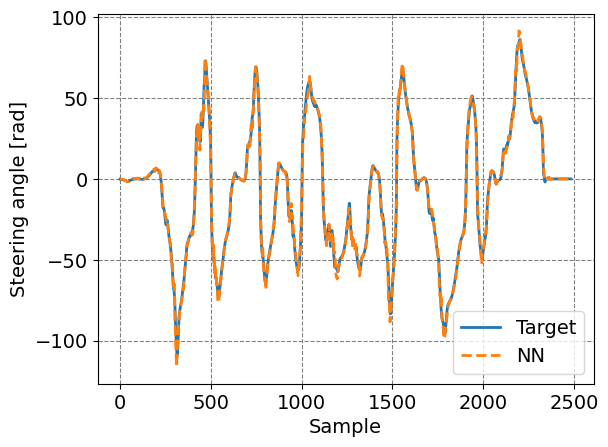

In [10]:
# Test on a new dataset
dataset_use = 'validation_set'
if dataset_use == 'training_set':
  num_samples_use = pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ay'].values.shape[0]-num_samples_future_feedfw
elif dataset_use == 'validation_set':
  num_samples_use = pd.read_csv(os.path.join(data_folder_valid,'telem_valid.csv'))['ay'].values.shape[0]-num_samples_future_feedfw
else:
  num_samples_use = 100
samples_test_set = steer_controller_extended.getSamples(dataset_use, index=0, window=num_samples_use) 
out_nn_test_set  = steer_controller_extended(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['steering_angle'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
rmse_calc = np.sqrt(mse_calc/len(samples_test_set_extract))
print('RMSE on the test set: ', np.rad2deg(rmse_calc), ' deg')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(np.rad2deg(samples_test_set_extract),label='Target',linewidth=2)
  plt.plot(np.rad2deg(out_nn_test_set_extract),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Steering angle [rad]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#steer_controller_ARD({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})